In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%matplotlib inline
from time import sleep
import time

import os
import sys
import h5py
import numpy as np
import pandas as pd
from scipy import signal
from scipy.ndimage.filters import gaussian_filter
import glob

import cv2
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [116]:
main = '/content/drive/My Drive/Colab Notebooks/CV_notebooks/project/'

In [189]:
def reduce_spatial(img, scale):
    width = int(img.shape[1] * scale / 100)
    height = int(img.shape[0] * scale / 100)
    dim = (width, height)
    # resize image
    resized = cv2.resize(img, dim, interpolation=cv2.INTER_AREA)
    return resized


def load_video(data_path, video_name, reduce=False):
  frames = []
  for i in sorted(glob.glob(data_path + '/' + video_name +'/*.png')):
    img = cv2.imread(i, 0)
    if reduce:
      img = reduce_spatial(img, 30)
    frames.append(img)
  frames = np.array(frames)
  return frames  


def calculateOF(frames, data_path, video_name, reduce=False, sub_mean=False, store=False, save_folder='opticalFlow'):
  t1 = time.time()
  height, width = frames.shape[1], frames.shape[2]
  u_list = np.zeros((frames.shape[0], height, width))
  v_list = np.zeros((frames.shape[0], height, width))

  # calculate OF with opencv
  for ff in range(1, frames.shape[0]):
    prvs = frames[ff-1] # - frames[ff-1].mean()
    next = frames[ff] # -  frames[ff].mean()
    if sub_mean:
      prvs = prvs - prvs.mean()
      next = next - next.mean()
    # add filtering
    # prvs = gaussian_filter(prvs, 1.5)
    # next = gaussian_filter(next, 1.5)
    flow = cv2.calcOpticalFlowFarneback(prvs, next, None, 0.5, 3, 25, 3, 5, 1.2, 0) # window 15
    u_list[ff, :, :] = flow[:,:,0]
    v_list[ff, :, :] = flow[:,:,1]
  print('Time to compute OF:', time.time() - t1)
  # save 
  if store:
    save_path = os.path.join(data_path, folder)
    os.makedirs(save_path, exist_ok=True)
    hf = h5py.File(save_path + '/' + video_name + '.h5', 'w')
    hf.create_dataset('u', data=u_list)
    hf.create_dataset('v', data=v_list)
    hf.close()

  return u_list, v_list


main = '/content/drive/My Drive/Colab Notebooks/CV_notebooks/project/'
names = ['fall-01-cam0-rgb', 'fall-06-cam0-rgb', 'fall-15-cam0-rgb', 'fall-27-cam0-rgb']
for name in names[2:3]:
  print('Processing video ', name)
  frames = load_video(main + 'data', name)
  u, v = calculateOF(frames, main, name)

Processing video  fall-15-cam0-rgb
Time to compute OF: 7.807873010635376


In [ ]:
# for our own videos
gif = cv2.VideoCapture(main + '/data/IMG_1002.MOV')

num_frames = int(gif.get(cv2.CAP_PROP_FRAME_COUNT))
height = int(gif.get(cv2.CAP_PROP_FRAME_HEIGHT)*0.3)
width = int(gif.get(cv2.CAP_PROP_FRAME_WIDTH)*0.3)
frames = np.zeros((num_frames, height, width))
for i in range(num_frames):
  ret, frame = gif.read()
  frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
  img = frame_gray
  scale_percent = 30 # percent of original size
  width = int(img.shape[1] * scale_percent / 100)
  height = int(img.shape[0] * scale_percent / 100)
  dim = (width, height)
  # resize image
  resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
  frames[i] = resized

u, v = calculateOF(frames, main, 'maia')

In [83]:
# load OF
import h5py
name = 'fall-27-cam0-rgb'

def loadOF(path, name):
  hf = h5py.File(path + name + '.h5', 'r')
  # hf = h5py.File(main + 'opticalFlow/maia.h5', 'r')
  u = hf.get('u')
  u = np.array(u)

  v = hf.get('v')
  v = np.array(v)
  hf.close()
  return u, v

folder = 'opticalFlow/nomean/'
u, v = loadOF(main + folder, name)

In [190]:
def get_signals(u, v):
  mag = u ** 2 + v ** 2
  orient  = np.arctan2(v, u) * 180/np.pi
  orient[orient < 0] += 360
  bins = []
  means = []
  for i in range(1, u.shape[0]):
    # filter magnitude using stats of each frame
    thrsh = max_deviations * mag[i].std()
    # thrsh = 0.3
    pos = np.where(mag[i] < thrsh)
    mag[i, pos[0], pos[1]] = 0

    filt_mag = mag[i][mag[i] >= thrsh]
    # append the mean magnitude above thrsh
    means.append(filt_mag.mean())

    hh, bb = np.histogram(orient[i].ravel(), bins=10, weights=mag[i].ravel(), density=True)
    bins.append(hh.argmax())

  return mag, means, bins


mag, means, bins = get_signals(u, v)

In [191]:
# load annotations
ann = pd.read_csv(main + 'urfall-cam0-falls_ann.csv')
sub = ann[ann['sequence_name']==name]
gt = sub['t_s'].values[0]
print(gt)

28


3.5197330760895937


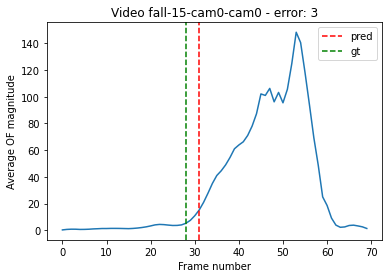

In [200]:
def get_prediction(means, gt, name, window, thrsh=1):
  mm = np.array(means)
  # depends on number of frames
  # calculate approximate derivative
  g = np.convolve(mm, np.ones(window)/window, 'same')
  der = np.diff(g)
  # thrsh = der.mean() + 1 * der.std() # std is too large
  thrsh = np.percentile(der, 75)
  print(thrsh)
  try:
    pred = np.where(der > thrsh)[0][0] + 1
    # pred = np.argmax(der) + 1 
  except:
    pred = 0

  plt.plot(g)
  plt.axvline(pred, color='r', linestyle='dashed', label='pred')
  plt.axvline(gt, color='g', linestyle='dashed', label='gt')
  plt.title('Video {}-cam0 - error: {}'.format(name[:-4], np.round(abs(gt-pred), 4)))
  # plt.title('Own video - error: {}'.format(np.round(abs(gt-pred), 4)))
  plt.xlabel('Frame number')
  plt.legend()
  plt.ylabel('Average OF magnitude')

  return pred, der

window = len(means) * 0.05
prediction, der = get_prediction(means, gt, name, int(window), 3)

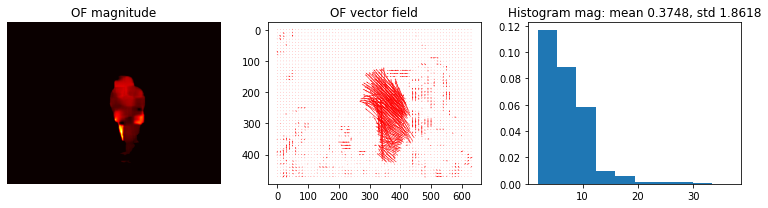

In [139]:
def visualize(mag, u, v, frame=None):
  if frame is not None:
    ids = [frame]
  else:
    ids = list(range(u.shape[0]))
  for ff in ids:
    clear_output(wait=True)
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(11, 3))
    width = u.shape[2]
    height = u.shape[1]
    x = np.arange(0, width, 1)
    y = np.arange(0, height, 1)
    x, y = np.meshgrid(x, y)
    step = 10
    ax1.imshow(mag[ff], cmap='hot', aspect='auto')
    ax1.set_title('OF magnitude')
    ax1.axis('off')
    # plt.subplot(132)
    ax2.quiver(x[::step, ::step], y[::step, ::step],
              u[ff][::step, ::step], v[ff][::step, ::step],
              color='r', pivot='middle', headwidth=2, headlength=3)
    ax2.invert_yaxis()
    ax2.set_title('OF vector field')
    # plt.subplot(133)
    thrsh = max_deviations * mag[i].std()
    filt_mag = mag[ff][mag[ff]>=thrsh]
    means.append(filt_mag.mean())
    ax3.hist(filt_mag.ravel(), bins=10, density=True)
    title = 'Histogram mag: mean {}, std {}'.format(np.round(mag[ff].mean(), 4), np.round(mag[ff].std(), 4))
    ax3.set_title(title)
    fig.tight_layout()

    plt.show()
    sleep(0.3)

visualize(mag, u, v, frame=prediction)

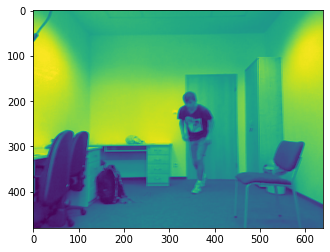

In [198]:
plt.imshow(frames[prediction])